In [1]:
import netCDF4
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f = netCDF4.Dataset('rtofs_glo_3dz_f024_daily_3zvio.nc')
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    title: HYCOM ATLb2.00
    institution: National Centers for Environmental Prediction
    source: HYCOM archive file
    experiment: 92.4
    history: archv2ncdf3z
    dimensions(sizes): MT(1), Y(3298), X(4500), Depth(33)
    variables(dimensions): float64 MT(MT), float64 Date(MT), float32 Depth(Depth), int32 Y(Y), int32 X(X), float32 Latitude(Y,X), float32 Longitude(Y,X), float32 v(MT,Depth,Y,X)
    groups: 



In [3]:
print(f.variables.keys()) # get all variable names

odict_keys(['MT', 'Date', 'Depth', 'Y', 'X', 'Latitude', 'Longitude', 'v'])


In [4]:
temp = f.variables['v']
print(temp)

<class 'netCDF4._netCDF4.Variable'>
float32 v(MT, Depth, Y, X)
    coordinates: Longitude Latitude Date
    standard_name: northward_sea_water_velocity
    units: m/s
    _FillValue: 1.2676506e+30
    valid_range: [-2.6110384  2.6092384]
    long_name:  v-veloc. [92.4H]
unlimited dimensions: MT
current shape = (1, 33, 3298, 4500)
filling on


In [5]:
for d in f.dimensions.items():
    print(d)

('MT', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'MT', size = 1
)
('Y', <class 'netCDF4._netCDF4.Dimension'>: name = 'Y', size = 3298
)
('X', <class 'netCDF4._netCDF4.Dimension'>: name = 'X', size = 4500
)
('Depth', <class 'netCDF4._netCDF4.Dimension'>: name = 'Depth', size = 33
)


In [6]:
print(temp.dimensions)
print(temp.shape)

('MT', 'Depth', 'Y', 'X')
(1, 33, 3298, 4500)


In [7]:
mt = f.variables['MT']
depth = f.variables['Depth']
x,y = f.variables['X'], f.variables['Y']
v = f.variables['v']
print(mt)
print(x)
print(v)

<class 'netCDF4._netCDF4.Variable'>
float64 MT(MT)
    long_name: time
    units: days since 1900-12-31 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: MT
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
int32 X(X)
    point_spacing: even
    axis: X
unlimited dimensions: 
current shape = (4500,)
filling on, default _FillValue of -2147483647 used

<class 'netCDF4._netCDF4.Variable'>
float32 v(MT, Depth, Y, X)
    coordinates: Longitude Latitude Date
    standard_name: northward_sea_water_velocity
    units: m/s
    _FillValue: 1.2676506e+30
    valid_range: [-2.6110384  2.6092384]
    long_name:  v-veloc. [92.4H]
unlimited dimensions: MT
current shape = (1, 33, 3298, 4500)
filling on


In [8]:
print(x.shape[0])

4500


In [9]:
time = mt[:]  # Reads the netCDF variable MT, array of one element
print(time)
dep = depth[:] # examine depth array
print(dep)

[42975.]
[   0.   10.   20.   30.   50.   75.  100.  125.  150.  200.  250.  300.
  400.  500.  600.  700.  800.  900. 1000. 1100. 1200. 1300. 1400. 1500.
 1750. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500.]


#### What is it?

In [10]:
print(temp[0, 2, 1, 1])

--


In [10]:
xx,yy = x[:],y[:]
print('shape of temp variable: %s' % repr(temp.shape))
tempslice = temp[0, dep < 100., yy > yy.max()/2, xx > xx.max()/2]
print('shape of temp slice: %s' % repr(tempslice.shape))

shape of temp variable: (1, 33, 3298, 4500)
shape of temp slice: (6, 1649, 2250)


In [11]:
lat, lng = f.variables['Latitude'], f.variables['Longitude']
print(lng)

<class 'netCDF4._netCDF4.Variable'>
float32 Longitude(Y, X)
    standard_name: longitude
    units: degrees_east
    modulo: 360 degrees
unlimited dimensions: 
current shape = (3298, 4500)
filling on, default _FillValue of 9.969209968386869e+36 used



In [12]:
# extract lat/lon values (in degrees) to numpy arrays
latvals = lat[:]; lngvals = lng[:] 
# a function to find the index of the point closest pt (in squared distance) to give lat/lon value.
def getclosest_ij(lats,lngs,latpt,lngpt):
    # find squared distance of every point on grid
    dist_sq = (lats-latpt)**2 + (lngs-lngpt)**2  
    # 1D index of minimum dist_sq element
    minindex_flat = dist_sq.argmin()    
    # Get 2D index for latvals and lonvals arrays from 1D index
    return np.unravel_index(minindex_flat, lats.shape)
iy_min, ix_min = getclosest_ij(latvals, lngvals, 50., -140)
print(iy_min, ix_min)

3296 50


### Решаем задачу: зная широту и долготу, найти квадрат (4 точки со значениями y и x) такой, что исходная точка лежит в этом квадрате

In [14]:
def pointSearch(pLat, pLng):
    goalX = -1
    goalY = -1
    epsX = 100.
    epsY = 100.
    for i in range(x.shape[0] - 1):
        if ((lngvals[0, i] - 255. <= pLng) & (lngvals[0, i + 1] - 255. > pLng) & (epsX > 0.01)):
            goalX = i
            epsX = pLng -  lngvals[0, i] + 255.
    if (goalX == -1):
        print('Smth with X went wrong')

    for j in range(y.shape[0] - 1):
        if (lngvals[j, goalX] - 255. > pLng):
            while (lngvals[j, goalX] - 255. > pLng):
                goalX -= 1
        if (lngvals[j, goalX + 1] - 255. < pLng):
            while (lngvals[j, goalX] - 255. < pLng):
                goalX += 1
        if ((latvals[j, goalX] <= pLat) & (latvals[j + 1, goalX] > pLat) & (epsY > 0.01)):
            goalY = j
            epsY = pLat - latvals[j, goalX]
    if (goalY == -1):
        print('Smth went wrong with Y')
            
            
    print(goalX, goalY)
    return (goalY, goalX)

In [15]:
a = pointSearch(78., -120.)
print(a)
print(latvals[a], lngvals[a])

1125 2963
(2963, 1125)
79.33128 164.2091


In [16]:
print(latvals[3297, 4400])
print(latvals[3270, 4400])
print(lngvals[3297, 4400])
print(lngvals[3270, 4400])

52.1838
52.1804
794.126
433.824


In [17]:
print(lngvals[0, 0])
print(lngvals[0, 4499])
print(lngvals[3297, 0])
print(lngvals[3297, 4499])

74.16
434.08
74.12
794.12


In [ ]:
print(lngvals.min())
print(lngvals[0:3296, :].max())

In [19]:
print(latvals.min())
print(latvals.max())

-78.64
89.9777


In [26]:
longit = np.zeros(x.shape[0] * y.shape[0])
for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        longit[i * y.shape[0] + j] = lngvals[j, i]

AttributeError: 'numpy.ndarray' object has no attribute 'length'

(array([  8.17220000e+04,   6.87370000e+04,   6.38450000e+04,
          6.28680000e+04,   5.83190000e+04,   5.64510000e+04,
          5.49470000e+04,   5.36240000e+04,   5.24970000e+04,
          5.15370000e+04,   5.06210000e+04,   5.20330000e+04,
          4.91040000e+04,   4.84450000e+04,   4.78480000e+04,
          4.72630000e+04,   4.67720000e+04,   4.62840000e+04,
          4.58340000e+04,   4.54290000e+04,   4.71870000e+04,
          4.46270000e+04,   4.42910000e+04,   4.39490000e+04,
          4.36490000e+04,   4.33480000e+04,   4.30820000e+04,
          4.28130000e+04,   4.47260000e+04,   4.22950000e+04,
          4.20660000e+04,   4.18650000e+04,   4.16530000e+04,
          4.14350000e+04,   4.12770000e+04,   4.10790000e+04,
          4.30750000e+04,   4.07190000e+04,   4.05680000e+04,
          4.04430000e+04,   4.02630000e+04,   4.01160000e+04,
          4.00340000e+04,   4.20340000e+04,   3.97600000e+04,
          3.96110000e+04,   3.95220000e+04,   3.93870000e+04,
        

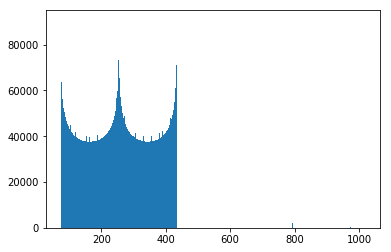

In [31]:
plt.hist(longit, bins = 900)

In [93]:
def searchPoint(pLat, pLng):
    if (pLat < -78.64):
        pLat = 89.
    if (pLat > 89.9502):
        pLat = -78.
    if (pLng < 74.119995):
        pLng = 494.
    if (pLng > 494.11987):
        pLng = 74.
    res = False
    i = 0
    j = 0
    counter = 0
    goal = [-1, -1]
    while (res == False):
        counter += 1
        if (counter > 7990):
            print("i, j: ", i, j)
        if (counter > 8000):
            return
        
        j = jmod(j)
        i = imod(i)
        
        p1 = [lngvals[j, i], latvals[j, i]] 
        p2 = [lngvals[j, imod(i+1)], latvals[j, imod(i+1)]]
        p3 = [lngvals[jmod(j+1), imod(i+1)], latvals[jmod(j+1), imod(i+1)]]
        p4 = [lngvals[jmod(j+1), i], latvals[jmod(j+1), i]]
        p = [pLng, pLat]
        out = cellIdentBool(p1, p2, p3, p4, p)
        if (counter > 7990):
            print(out)
        if ((not out[0][0]) | (not out[1][0])) :
            if (not out[0][0]):
                i = (i-1) % x.shape[0]
            if (not out[1][0]):
                j = (j-1) % y.shape[0]
        else:
            if (not out[2][0]):
                i = (i+1) % x.shape[0]
            if (not out[3][0]):
                j = (j+1) % y.shape[0]
        if (out[0][0] & out[1][0] & out[2][0] & out[1][0]):
            goal = [j, i]
            res = True
            print(res)
    return goal

In [69]:
def imod(i):
    return i % x.shape[0]

def jmod(j):
    return j % y.shape[0]

In [59]:
def cellIdentBool(P1, P2, P3, P4, P):
    ex = [P2[0]-P1[0],P2[1]-P1[1]]
    ey = [P4[0]-P1[0],P4[1]-P1[1]]
    exs = [P4[0]-P3[0],P4[1]-P3[1]]
    eys = [P2[0]-P3[0],P2[1]-P3[1]]
    
    a = np.array([[ex[0], ey[0]], [ex[1], ey[1]]])
    b = np.array([P[0]-P1[0], P[1]-P1[1]])
    xxx = np.linalg.solve(a, b)
    c = np.array([[exs[0], eys[0]], [exs[1], eys[1]]])
    b = np.array([P[0]-P3[0], P[1]-P3[1]])
    yyy = np.linalg.solve(c, b)
    return ([xxx[0]>=0], [xxx[1]>=0], [yyy[0]>=0], [yyy[1]>=0])

In [56]:
print(cellIdentBool([0.,0.], [1.,0.], [1.,1.], [0.,1.], [-0.5,-0.6])[2][0])

True


In [95]:
goal = searchPoint(-25., 100.)
print(goal)
print(latvals[goal[0], goal[1]], lngvals[goal[0], goal[1]])

True
[323, 322]
-68.304 99.920044


In [90]:
print(lngvals[1516, 4498], latvals[1516, 4498])
print(lngvals[1516, 4499], latvals[1516, 4499])
print(lngvals[1516, 0], latvals[1516, 0])

434.0 0.9599551
434.07996 0.9599551
74.160034 0.9599551
